In [1]:
%pylab inline
import twx

Populating the interactive namespace from numpy and matplotlib


# Question 1

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab

In [3]:
def generate_serie(y0, length = 252*10, vol=0.2, g=0.22, gamma=1.15, tau=1/252, T=500):
    ys = [y0]
    vols = [vol]
    sigma = vol
    y = y0
    factor = g/(vol**2*tau)
    for _ in range(length):
        omega = np.random.normal(0,1)
        y = y + sigma*omega*np.sqrt(tau)
        ys.append(y)
        t = len(ys)
        sigma = 0
        for l in range(1, min(t,T)+1, 1):
            sigma += factor/l**gamma*(y-ys[t-l])**2/l
        sigma += 1
        sigma = np.sqrt(sigma)*vol
        vols.append(sigma)
        
    return ys, vols

In [15]:
y0 = np.log(10)
np.random.seed(123)
logprices, vols = generate_serie(y0)

In [16]:
df = pd.DataFrame(logprices)
df.columns = ['Log Prices']
df['Prices'] = np.exp(df['Log Prices'])
df['MultiScale Vols'] = vols

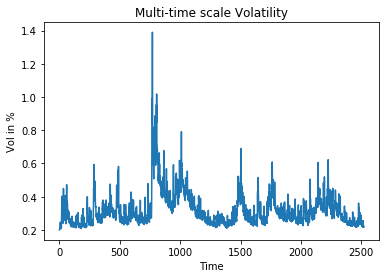

In [17]:
plt.xlabel('Time')
plt,ylabel('Vol in %')
plt.title('Multi-time scale Volatility')
df['MultiScale Vols'].plot()

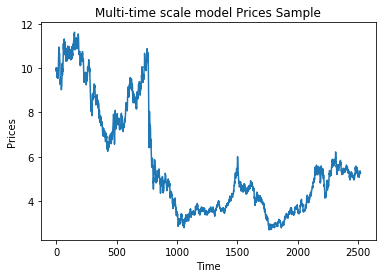

In [18]:
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Multi-time scale model Prices Sample')
df['Prices'].plot()

In [36]:
df['Returns'] = df['Prices']/df['Prices'].shift(1)-1

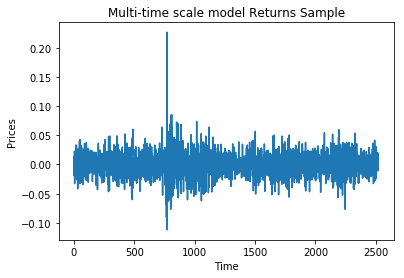

In [37]:
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Multi-time scale model Returns Sample')
df['Returns'].plot()

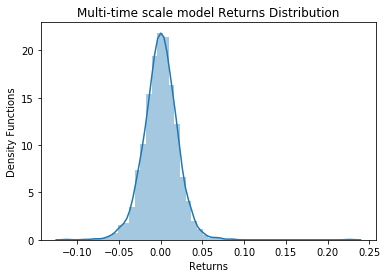

In [38]:
plt.xlabel('Time')
plt.ylabel('Density Functions')
plt.title('Multi-time scale model Returns Distribution')
sns.distplot(df['Returns'])

# Question 2

We try several ideas to compare our model's returns distribution to a gaussian simulation:

* Plotting the two distributions
* Q-Q plot

In [42]:
gauss = np.random.normal(0, 0.2*1/np.sqrt(252), len(df['Returns']))

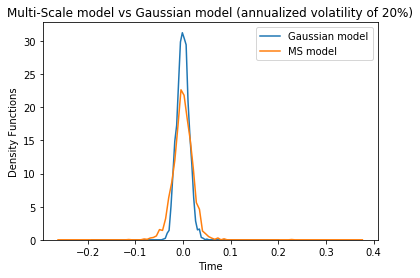

In [45]:
sns.kdeplot(gauss, bw=.05, label="Gaussian model")
sns.kdeplot(df['Returns'], bw=.05, label="MS model")
plt.xlabel('Time')
plt.ylabel('Density Functions')
plt.title('Multi-Scale model vs Gaussian model (annualized volatility of 20%)')
plt.legend();

We can notice by eye that the tails of the Multi-Scale model are fatter

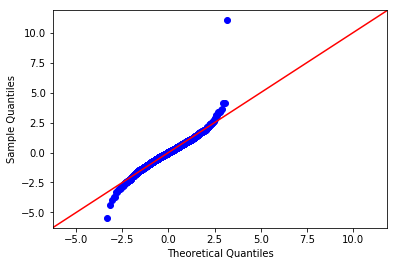

In [52]:
sm.qqplot((df['Returns']-df['Returns'].mean())/df['Returns'].std(), line='45')
pylab.show()

Here again, it is obvious that our standardized returns have fatter tails then a standard gaussian distribution. This is interesting as we know that the standard brownian motion model does not account for fat tail probabilities: huge deviations from the mean can be observed during market events (crisis) more often that hwta such a model accounts for. Here, we model this stylized fact of the market better.

However, we could say that fait tail are more important for negative values (negatively skewded distribution), which does not seem to be clear here.

# Question 3

In [53]:
df['SR'] = df['Returns']**2

In [59]:
from statsmodels.graphics.tsaplots import plot_acf

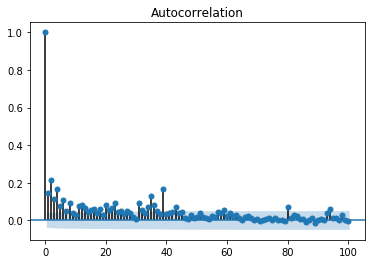

In [64]:
plot_acf(df['SR'].dropna(), lags=100)
pyplot.show()

We can observe that squared returns are highly correlated for lags between 1 and 20 days: a high autocorrelation will imply volatility clusters by definition.

# Question 4

In [93]:
sdate = datetime.date(2010, 4, 1)   # start date
edate = datetime.date(2020, 4, 1)   # end date

dates = [sdate + datetime.timedelta(days=i) for i in range((edate - sdate).days + 1)]

table = [[date, 'AAPL'] for date in dates]
data = twx.bookjoin(table, 'daily.open' ,symbol= 'AAPL' )

In [94]:
data.shape
data.head(10)

,0,1,daily.open
0,2010-04-01,AAPL,29.4501
1,2010-04-02,AAPL,NaN
2,2010-04-03,AAPL,NaN
3,2010-04-04,AAPL,NaN
4,2010-04-05,AAPL,29.1383
5,2010-04-06,AAPL,29.5382
6,2010-04-07,AAPL,29.7267
7,2010-04-08,AAPL,29.8160
8,2010-04-09,AAPL,29.9387
9,2010-04-10,AAPL,NaN


In [95]:
data.drop(columns = ['1'], inplace = True)
data.dropna(inplace = True)

In [96]:
data.set_index('0', inplace = True)
data.columns = ['Prices']

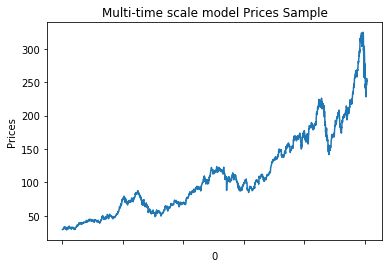

In [97]:
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Multi-time scale model Prices Sample')
data['Prices'].plot()

In [98]:
data['Returns'] = data['Prices']/data['Prices'].shift(1)-1
data.head()

,Prices,Returns
0,,
2010-04-01,29.4501,NaN
2010-04-05,29.1383,-0.010587
2010-04-06,29.5382,0.013724
2010-04-07,29.7267,0.006382
2010-04-08,29.8160,0.003004


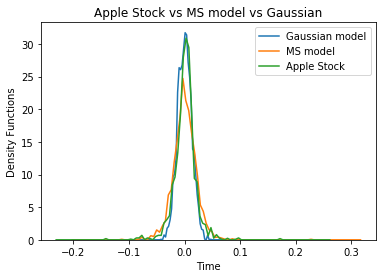

In [103]:
gauss = np.random.normal(0, 0.2*1/np.sqrt(252), len(data['Returns']))
sns.kdeplot(gauss, bw=.03, label="Gaussian model")
sns.kdeplot(df['Returns'], bw=.03, label="MS model")
sns.kdeplot(data['Returns'], bw=.03, label="Apple Stock")
plt.xlabel('Time')
plt.ylabel('Density Functions')
plt.title('Apple Stock vs MS model vs Gaussian')
plt.legend();

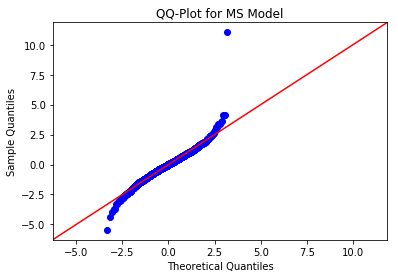

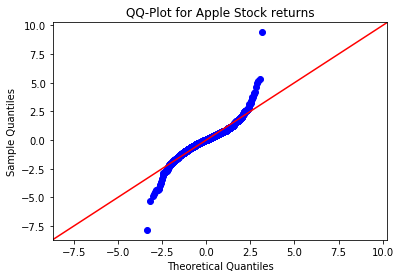

In [106]:
sm.qqplot((df['Returns']-df['Returns'].mean())/df['Returns'].std(), line='45')
plt.title('QQ-Plot for MS Model')
sm.qqplot((data['Returns']-data['Returns'].mean())/data['Returns'].std(), line='45')
plt.title('QQ-Plot for Apple Stock returns')
pylab.show()

Apple stock still has fatter tails than our model, especially for negative values

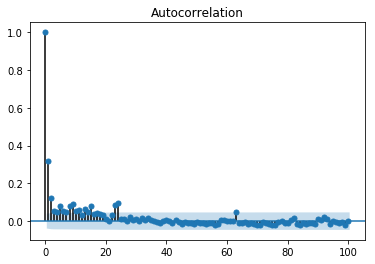

In [107]:
data['SR'] = data['Returns']**2
plot_acf(data['SR'].dropna(), lags=100)
pyplot.show()

The autocorrelation also seems to be lower then what the model proposes